In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')

from scipy.stats import zscore
from scipy.stats import skew
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [2]:
# Load dataset
df= pd.read_csv("diabetic_data.csv")

In [3]:
# Data head
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


### Dropping the columns

In [4]:
df.drop(['weight','payer_code','encounter_id', 'patient_nbr'],axis=1,inplace=True)

### Replacing the missing values

In [5]:
# Replace missing values in the race column with the most frequent value
df['race'] = df['race'].fillna(df['race'].mode()[0])

In [9]:
# Replace missing values in the 'medical_specialty' column with the mode of the column
df['medical_specialty'] = df['medical_specialty'].fillna(df['medical_specialty'].mode()[0])

In [6]:
import re #regex!

# Define a function to clean the age column
def clean_age(age):
    age = str(age) # Convert to string
    age = re.sub('[^0-9\-]', '', age) # Remove any non-numeric characters
    age = age.split('-') # Split the string into a list of values
    age = [int(x) for x in age if x != ''] # Convert each value to an integer and remove any empty strings
    if len(age) == 1:
        return age[0]
    else:
        return sum(age)/2 # Return the average of the lower and upper bounds of the age group

# Apply the clean_age function to the age column
df['age'] = df['age'].apply(clean_age)

In [7]:
bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
labels = ['0-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100', '100-110']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, include_lowest=True)


### Feature Engg.

In [13]:
# Create a binary feature indicating whether a patient has been readmitted
df['readmitted_binary'] = np.where(df['readmitted'] == 'NO', '0', '1')

# Create a feature indicating the total number of diagnoses for each patient
df['total_diagnoses'] = df['number_diagnoses'] + df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']

In [8]:
# Combine the diagnosis codes
for col in ['diag_1', 'diag_2', 'diag_3']:
    df[col] = df[col].replace('?', np.nan) # Replace '?' with NaN
    df[col] = pd.to_numeric(df[col], errors='coerce') # Convert the column to a numerical column
    df.loc[(df[col] >= 390) & (df[col] < 400), col] = 1 # Circulatory system
    df.loc[(df[col] >= 401) & (df[col] < 410), col] = 2 # Respiratory system
    df.loc[(df[col] >= 410) & (df[col] < 460) | (df[col] == 785), col] = 3 # Digestive system
    df.loc[(df[col] >= 460) & (df[col] < 520) | (df[col] == 786), col] = 4 # Musculoskeletal system
    df.loc[(df[col] >= 520) & (df[col] < 580) | (df[col] == 787), col] = 5 # Genitourinary system
    df.loc[(df[col] >= 580) & (df[col] < 630) | (df[col] == 788), col] = 6 # Neoplasms
    df.loc[(df[col] >= 800) & (df[col] < 1000), col] = 7 # Injury and poisoning
    df.loc[(df[col] >= 710) & (df[col] < 740), col] = 8 # Congenital anomalies
    df.loc[(df[col] >= 140) & (df[col] < 240), col] = 9 # Other
    df.loc[(df[col] >= 240) & (df[col] < 280), col] = 10 # Other
    df.loc[(df[col] >= 680) & (df[col] < 710) | (df[col] >= 782) & (df[col] < 784) | (df[col] >= 790) & (df[col] < 800) | (df[col] >= 240) & (df[col] < 250), col] = 11 # Other
    df[col] = df[col].astype('category') # Convert the column to a categorical column


In [14]:
#split dataset in features and target variable
feature_cols = ['age','readmitted_binary','total_diagnoses','time_in_hospital', 'num_medications', 'num_lab_procedures','num_procedures', 'number_outpatient', 'number_emergency', 'number_inpatient']

X = df[feature_cols] # Features
y = df.readmitted # Target variable

In [15]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test


In [16]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)


In [17]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8274156567310842


In [18]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)

Confusion matrix

 [[  923  2397     0]
 [ 2872  7789     0]
 [    0     0 16549]]


criterion : optional (default=”gini”) or Choose attribute selection measure. This parameter allows us to use the different-different attribute selection measure. Supported criteria are “gini” for the Gini index and “entropy” for the information gain.

splitter : string, optional (default=”best”) or Split Strategy. This parameter allows us to choose the split strategy. Supported strategies are “best” to choose the best split and “random” to choose the best random split.

max_depth : int or None, optional (default=None) or Maximum Depth of a Tree. The maximum depth of the tree. If None, then nodes are expanded until all the leaves contain less than min_samples_split samples. The higher value of maximum depth causes overfitting, and a lower value causes underfitting (Source).

## Optimizing decision tree

In [19]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.891057975761546


Model accuracy score with criterion entropy: 0.8911


[Text(0.375, 0.875, 'X[1] <= 0.5\nentropy = 1.366\nsamples = 71236\nvalue = [8037, 24884, 38315]'),
 Text(0.25, 0.625, 'entropy = 0.0\nsamples = 38315\nvalue = [0, 0, 38315]'),
 Text(0.5, 0.625, 'X[9] <= 4.5\nentropy = 0.802\nsamples = 32921\nvalue = [8037, 24884, 0]'),
 Text(0.25, 0.375, 'X[9] <= 1.5\nentropy = 0.789\nsamples = 31745\nvalue = [7506, 24239, 0]'),
 Text(0.125, 0.125, 'entropy = 0.772\nsamples = 25844\nvalue = [5849, 19995, 0]'),
 Text(0.375, 0.125, 'entropy = 0.857\nsamples = 5901\nvalue = [1657, 4244, 0]'),
 Text(0.75, 0.375, 'X[9] <= 7.5\nentropy = 0.993\nsamples = 1176\nvalue = [531, 645, 0]'),
 Text(0.625, 0.125, 'entropy = 0.981\nsamples = 884\nvalue = [370, 514, 0]'),
 Text(0.875, 0.125, 'entropy = 0.992\nsamples = 292\nvalue = [161, 131, 0]')]

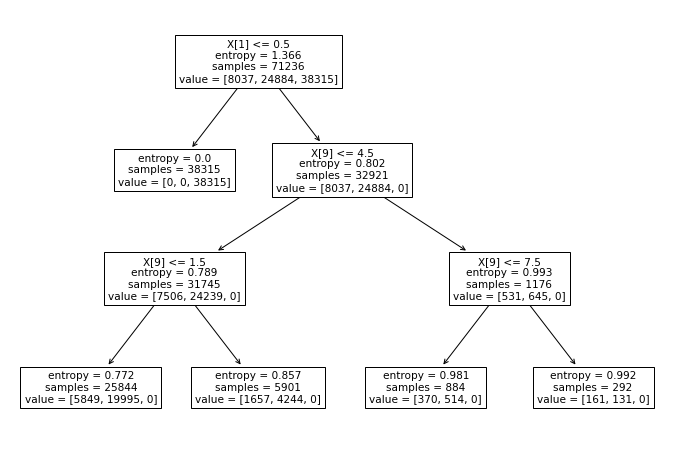

In [20]:
from sklearn.metrics import accuracy_score
print('Model accuracy score with criterion entropy: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
y_pred_train = clf.predict(X_train)
y_pred_train
plt.figure(figsize=(12,8))
from sklearn import tree
tree.plot_tree(clf.fit(X_train, y_train))

In [24]:
# Create Decision Tree classifer object
clf_gini = DecisionTreeClassifier(criterion="gini", max_depth=3)

# Train Decision Tree Classifer
clf_gini = clf_gini.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf_gini.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.891057975761546


In [22]:

cm_gini = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm_gini)

Confusion matrix

 [[   57  3263     0]
 [   63 10598     0]
 [    0     0 16549]]


[Text(0.375, 0.875, 'X[1] <= 0.5\ngini = 0.576\nsamples = 71236\nvalue = [8037, 24884, 38315]'),
 Text(0.25, 0.625, 'gini = 0.0\nsamples = 38315\nvalue = [0, 0, 38315]'),
 Text(0.5, 0.625, 'X[9] <= 4.5\ngini = 0.369\nsamples = 32921\nvalue = [8037, 24884, 0]'),
 Text(0.25, 0.375, 'X[9] <= 1.5\ngini = 0.361\nsamples = 31745\nvalue = [7506, 24239, 0]'),
 Text(0.125, 0.125, 'gini = 0.35\nsamples = 25844\nvalue = [5849, 19995, 0]'),
 Text(0.375, 0.125, 'gini = 0.404\nsamples = 5901\nvalue = [1657, 4244, 0]'),
 Text(0.75, 0.375, 'X[9] <= 7.5\ngini = 0.495\nsamples = 1176\nvalue = [531, 645, 0]'),
 Text(0.625, 0.125, 'gini = 0.487\nsamples = 884\nvalue = [370, 514, 0]'),
 Text(0.875, 0.125, 'gini = 0.495\nsamples = 292\nvalue = [161, 131, 0]')]

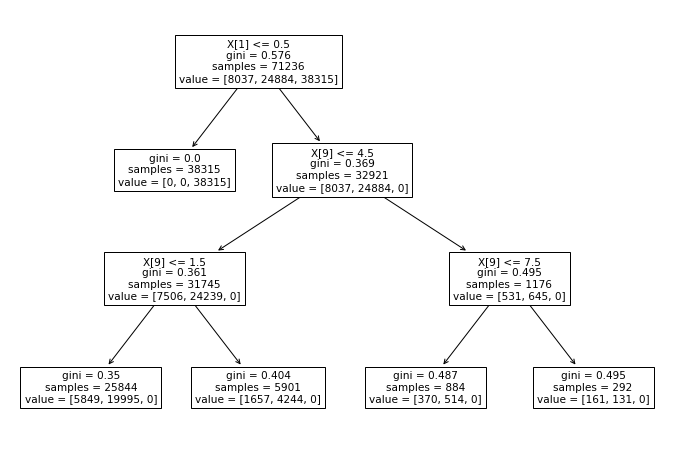

In [25]:
# Visualize decision tree
plt.figure(figsize=(12,8))
tree.plot_tree(clf_gini.fit(X_train, y_train))